In [2]:
!pip install transformers datasets accelerate torch bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
import torch

# Load AG News dataset
dataset = load_dataset("ag_news")

# Check dataset structure
print(dataset)
print(dataset['train'][0]) 

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-21 02:03:54.304364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 02:03:55.450190: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-21 02:03:55.450336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could

In [3]:

def prepare_text_data(example):
    return {"text": example["text"]}


processed_dataset = dataset.map(prepare_text_data, remove_columns=dataset["train"].column_names)

print(processed_dataset["train"][0])

Map: 100%|██████████| 7600/7600 [00:00<00:00, 16929.95 examples/s]{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}



In [4]:
# Define the ratio (e.g., 10%)
limit_ratio = 0.1

# Calculate the limit for the dataset
train_limit = int(len(processed_dataset["train"]) * limit_ratio)
test_limit = int(len(processed_dataset["test"]) * limit_ratio)

# Select a subset of the dataset
limited_train_dataset = processed_dataset["train"].select(range(train_limit))
limited_test_dataset = processed_dataset["test"].select(range(test_limit))

# Check the size of the limited dataset
print(f"Original train size: {len(processed_dataset['train'])}")
print(f"Limited train size: {len(limited_train_dataset)}")


Original train size: 120000
Limited train size: 12000


In [5]:
!pip install huggingface-cli


ERROR: Could not find a version that satisfies the requirement huggingface-cli (from versions: none)
ERROR: No matching distribution found for huggingface-cli

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Ensure the tokenizer has a pad token
tokenizer.pad_token = tokenizer.eos_token

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_and_prepare_labels(example):
    tokens = tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()  # Labels should match input_ids for language modeling
    return tokens


tokenized_train_dataset = limited_train_dataset.map(
    tokenize_and_prepare_labels,
    batched=True,
    remove_columns=["text"]
)
tokenized_test_dataset = limited_test_dataset.map(
    tokenize_and_prepare_labels,
    batched=True,
    remove_columns=["text"]
)

# Format the datasets for PyTorch
tokenized_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 760/760 [00:00<00:00, 5229.65 examples/s]


In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer

model_name = "t5-small"  

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def tokenize_and_prepare_labels(example):
    tokens = tokenizer(
        example["text"], 
        padding="max_length",
        truncation=True,
        max_length=128
    )
    tokens["labels"] = tokens["input_ids"].copy() 
    return tokens

tokenized_train_dataset = limited_train_dataset.map(
    tokenize_and_prepare_labels,
    batched=True,
    remove_columns=["text"] 
)
tokenized_test_dataset = limited_test_dataset.map(
    tokenize_and_prepare_labels,
    batched=True,
    remove_columns=["text"]
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./t5-small-news",
    evaluation_strategy="epoch",      
    save_strategy="epoch",           
    learning_rate=5e-5,
    per_device_train_batch_size=8,   
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,      # Save the best model
    fp16=True,                        # Enable mixed precision for speedup
    report_to="none",                 # Disable reporting to platforms like WandB
)

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,  # Add tokenizer for compatibility with text generation
)

trainer.train()

# Save the model and tokenizer
model.save_pretrained("./t5-small-finetuned")
tokenizer.save_pretrained("./t5-small-finetuned")


Map: 100%|██████████| 760/760 [00:00<00:00, 4079.44 examples/s]
/root/venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_95/742397431.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.242, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


('./t5-small-finetuned/tokenizer_config.json',
 './t5-small-finetuned/special_tokens_map.json',
 './t5-small-finetuned/tokenizer.json')

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("./t5-small-finetuned")
tokenizer = AutoTokenizer.from_pretrained("./t5-small-finetuned")

input_text = "Breaking news: The government has announced"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
output = model.generate(input_ids, max_length=50, num_return_sequences=1)

# Decode and print
print(tokenizer.decode(output[0], skip_special_tokens=True))

Breaking news: The government has announced


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
import torch

model = AutoModelForSeq2SeqLM.from_pretrained("./t5-small-finetuned")
tokenizer = AutoTokenizer.from_pretrained("./t5-small-finetuned")

def generate_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model.encoder(**inputs)  # generez embeddings
        embedding = outputs.last_hidden_state.mean(dim=1) 
    return embedding.squeeze()

sentence1 = "Sky is blue."
sentence2 = "Car is red."

embedding1 = generate_embedding(sentence1)
embedding2 = generate_embedding(sentence2)

similarity = cosine_similarity(embedding1.unsqueeze(0).numpy(), embedding2.unsqueeze(0).numpy())
print(f"Cosine Similarity: {similarity[0][0]:.4f}")


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-21 03:58:59.276197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 03:59:00.528257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-11-21 03:59:00.528450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could

Pre-trained Model Metrics:
Accuracy: 0.40, Precision: 0.67, Recall: 0.29, F1-Score: 0.40

Fine-tuned Model Metrics:
Accuracy: 0.30, Precision: 0.50, Recall: 0.29, F1-Score: 0.36


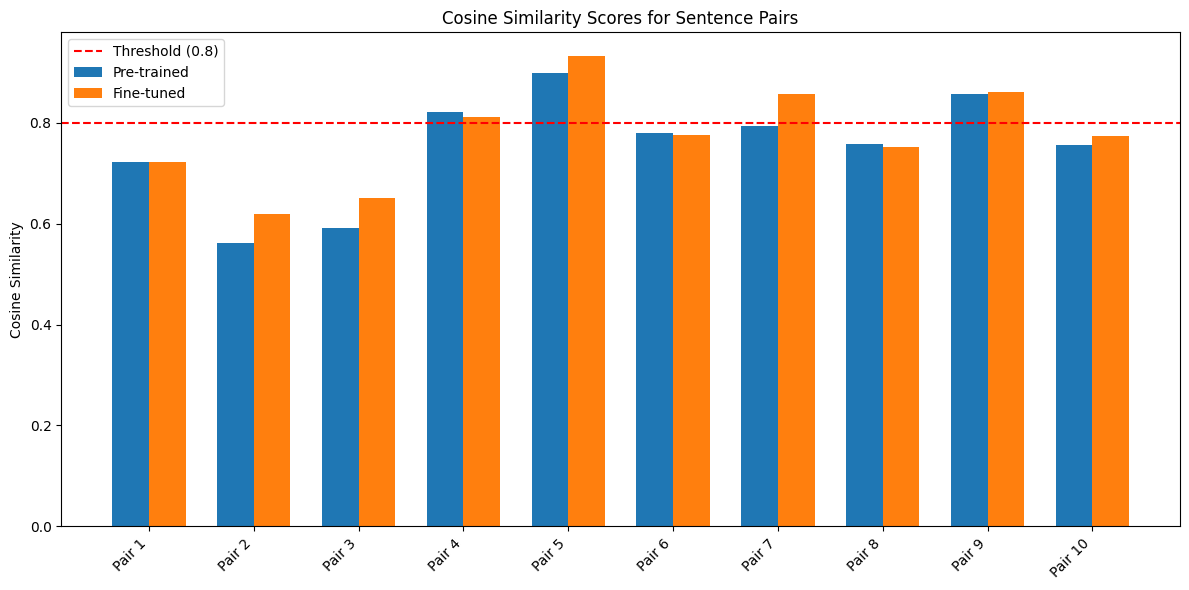

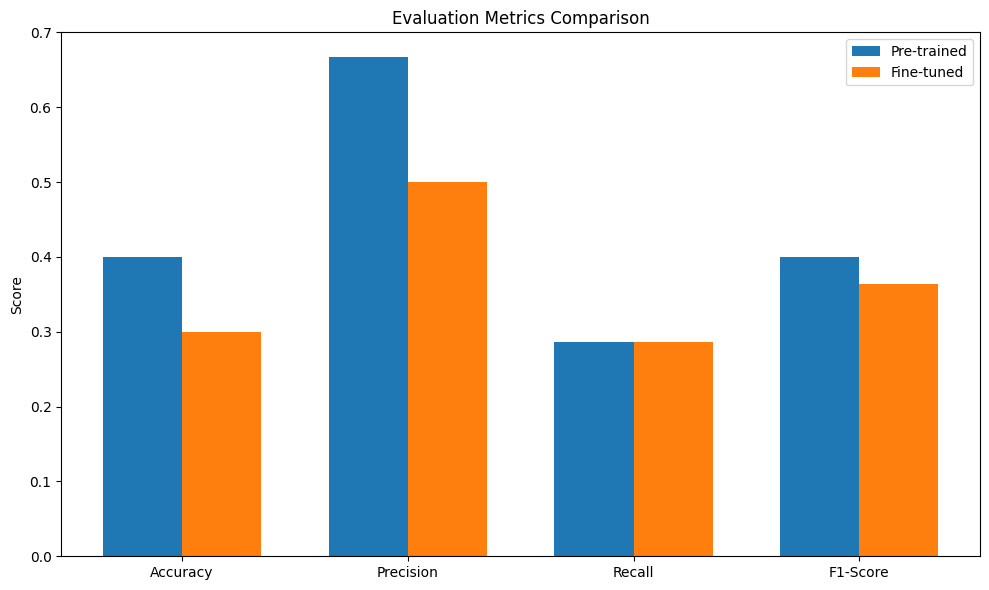

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load fine-tuned and pre-trained models
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained("./t5-small-finetuned")
pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

tokenizer = AutoTokenizer.from_pretrained("t5-small")

# Function to generate embeddings
def generate_embedding(model, sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model.encoder(**inputs)  # Use the encoder for embeddings
        embedding = outputs.last_hidden_state.mean(dim=1)  # Pooling over sequence length
    return embedding.squeeze()

# 10 pairs of sentences
sentence_pairs = [
    ("The government announced new policies", "Policies announced by the government"),
    ("Sky is blue", "Grass is green"),
    ("Breaking news on elections", "Elections are the main headline"),
    ("A dog barks at night", "Dogs often bark at night"),
    ("The sun rises in the east", "The sun sets in the west"),
    ("Walking is good for health", "Running helps improve health"),
    ("The apple is red", "The orange is orange"),
    ("New study on climate change", "Research shows global warming effects"),
    ("Children are playing in the park", "Kids are having fun in the playground"),
    ("AI models are improving rapidly", "Artificial intelligence is evolving fast"),
]

# Ground truth similarity labels (1 = similar, 0 = not similar)
ground_truth_labels = [1, 0, 1, 1, 0, 1, 0, 1, 1, 1]

results = {"pretrained": [], "finetuned": []}

for model_name, model in [("pretrained", pretrained_model), ("finetuned", finetuned_model)]:
    similarities = []
    for sentence1, sentence2 in sentence_pairs:
        embedding1 = generate_embedding(model, sentence1)
        embedding2 = generate_embedding(model, sentence2)
        similarity = cosine_similarity(embedding1.unsqueeze(0).numpy(), embedding2.unsqueeze(0).numpy())[0][0]
        similarities.append(similarity)
    results[model_name] = similarities

threshold = 0.8
pretrained_predictions = [1 if sim >= threshold else 0 for sim in results["pretrained"]]
finetuned_predictions = [1 if sim >= threshold else 0 for sim in results["finetuned"]]

def calculate_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return accuracy, precision, recall, f1

pretrained_metrics = calculate_metrics(pretrained_predictions, ground_truth_labels)
finetuned_metrics = calculate_metrics(finetuned_predictions, ground_truth_labels)

print("Pre-trained Model Metrics:")
print(f"Accuracy: {pretrained_metrics[0]:.2f}, Precision: {pretrained_metrics[1]:.2f}, Recall: {pretrained_metrics[2]:.2f}, F1-Score: {pretrained_metrics[3]:.2f}")

print("\nFine-tuned Model Metrics:")
print(f"Accuracy: {finetuned_metrics[0]:.2f}, Precision: {finetuned_metrics[1]:.2f}, Recall: {finetuned_metrics[2]:.2f}, F1-Score: {finetuned_metrics[3]:.2f}")

# Plot results
labels = [f"Pair {i+1}" for i in range(len(sentence_pairs))]

# Similarity comparison plot
plt.figure(figsize=(12, 6))
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, results["pretrained"], width, label="Pre-trained")
plt.bar(x + width/2, results["finetuned"], width, label="Fine-tuned")

plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold (0.8)")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity Scores for Sentence Pairs")
plt.legend()
plt.tight_layout()
plt.show()

# Metric comparison plot
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
pretrained_vals = list(pretrained_metrics)
finetuned_vals = list(finetuned_metrics)

x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, pretrained_vals, width, label="Pre-trained")
plt.bar(x + width/2, finetuned_vals, width, label="Fine-tuned")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Evaluation Metrics Comparison")
plt.legend()
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d903e64f-d7d3-40a4-8200-1b05b0b1800a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>